## corv: Validations Off Of Falcon et. al, 2010

[GitHub Page](https://github.com/vedantchandra/corv)

---

Table Of Contents:

1. [Validation Without Templates](#validation-no-template)
2. [Validation With Templates](#validation-template)
3. [Comparison Of Methods](#validation-betwixt)

---

In order to establish that `corv` actually works, we can compare the radial velocities it calculates to DA radial velocities calculated from high-resolution spectra by [Falcon et.al, 2010](https://ui.adsabs.harvard.edu/abs/2010ApJ...712..585F/abstract). We use the sample of DA white dwarfs with spectra from [Chandra et.al, 2020](https://iopscience.iop.org/article/10.3847/1538-4357/aba8a2) and cross-match with the Falcon catalog based on position. Then we run `corv` on each spectrum, and compare the two.

<a id="validation-no-template"></a>

**01. Validating RVs Without Templates (Need to check/proofread)**

---

First we validate `corv` in the simplest case: without template fitting.

In [1]:
### General
import numpy as np
import matplotlib.pyplot as plt

from astropy.table import Table, Column, MaskedColumn, join
from astroquery.sdss import SDSS

from tqdm import tqdm

import corv
#corv.sdss.make_catalogs()

/Users/vedantchandra/0_research/01_sdss5/006_build_corv/data/comm_cat/
star and exposure catalogs not found! check paths and run make_catalogs() if you want to use sdss functionality. otherwise ignore.


In [2]:
# Read in the catalogs for comparison
catalog = Table.read('data/sed_radii.fits')
falcon = Table.read('data/falcon2010.fit')

# Initialize the corv rv arrays
catalog['corv_rv'] = -9999 * np.ones(len(catalog))
catalog['corv_erv'] = -9999 * np.ones(len(catalog))

In [3]:
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.table import  join_skycoord
from astropy import table

# Create a column with SkyCoord positions for easy matching
catalog['wd_pos'] = SkyCoord(catalog['ra'], catalog['dec'], unit='deg')
falcon['wd_pos'] = SkyCoord(falcon['_RA'], falcon['_DE'], unit='deg')

# Match Falcon's and Vedant's catalogs by taking targets within 5 arcsec
join_func = table.join_skycoord(5 * u.arcsecond)
falcon_xmatch = table.join(catalog, falcon, join_funcs={'wd_pos': join_skycoord(5 * u.arcsec)})

In [4]:
figs = []

for j in tqdm( range(len(falcon_xmatch))):
    # Extract SDSS plate, mjd, and fiberID from each target in both catalogs
    p,m,f = np.array(falcon_xmatch['col_p_m_f'][j].split('-')).astype(float)
    
    # Query SDSS for spectra 
    xid = SDSS.query_specobj(plate = p, mjd = m, fiberID = f)
    sp = SDSS.get_spectra(matches=xid)
    
    # Get pertinent spectrum data    
    wl = np.array(10**sp[0][1].data['loglam'])
    fl = np.array(sp[0][1].data['flux'])
    ivar = np.array(sp[0][1].data['ivar'])
            
    # Make & fit a corv model without templates
    corvmodel = corv.models.make_balmer_model(nvoigt = 2, names = ['a','b','g','d'])
    param_res, rv_res, rv_init = corv.fit.fit_corv(wl, fl, ivar, corvmodel)        
        
    # Add that to the list
    falcon_xmatch['corv_rv'][j] = (rv_res.params['RV'].value)
    falcon_xmatch['corv_erv'][j] = (rv_res.params['RV'].stderr)

  0%|                                                                                            | 0/97 [00:00<?, ?it/s]/home/arseneau/anaconda3/lib/python3.9/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),
100%|███████████████████████████████████████████████████████████████████████████████████| 97/97 [03:41<00:00,  2.29s/it]


In [5]:
mask_voigt = np.all([np.abs(falcon_xmatch['corv_rv']) < 2500, falcon_xmatch['s_n'] > 10], axis = 0)

rmse = 0
mae = 0
for i in range(len(falcon_xmatch['Adp-V'][mask_voigt])):
    rmse += (falcon_xmatch['Adp-V'][mask_voigt][i] - falcon_xmatch['corv_rv'][mask_voigt][i])**2
    mae += np.abs(falcon_xmatch['Adp-V'][mask_voigt][i] - falcon_xmatch['corv_rv'][mask_voigt][i])
    
rmse = np.sqrt( rmse / len(falcon_xmatch['Adp-V'][mask_voigt]))
mae = mae / len(falcon_xmatch['Adp-V'][mask_voigt])
bias = np.average(falcon_xmatch['Adp-V'][mask_voigt] - falcon_xmatch['corv_rv'][mask_voigt])

print('rmse: {:2.1f} km/s'.format(rmse))
print('mae: {:2.1f} km/s'.format(mae))
print('bias: {:2.1f} km/s'.format(bias))

rmse: 19.5 km/s
mae: 12.4 km/s
bias: 0.8 km/s


In [6]:
from math import isnan

for i in range(len(falcon_xmatch)):
    if isnan(falcon_xmatch['corv_erv'][i]):
        falcon_xmatch['corv_erv'][i] = mae

In [7]:
falcon_xmatch['corv_erv'] = np.sqrt(falcon_xmatch['corv_erv']**2 + mae**2)

Text(0, 0.5, 'RV (corv, Voigt profiles) $[km/s]$')

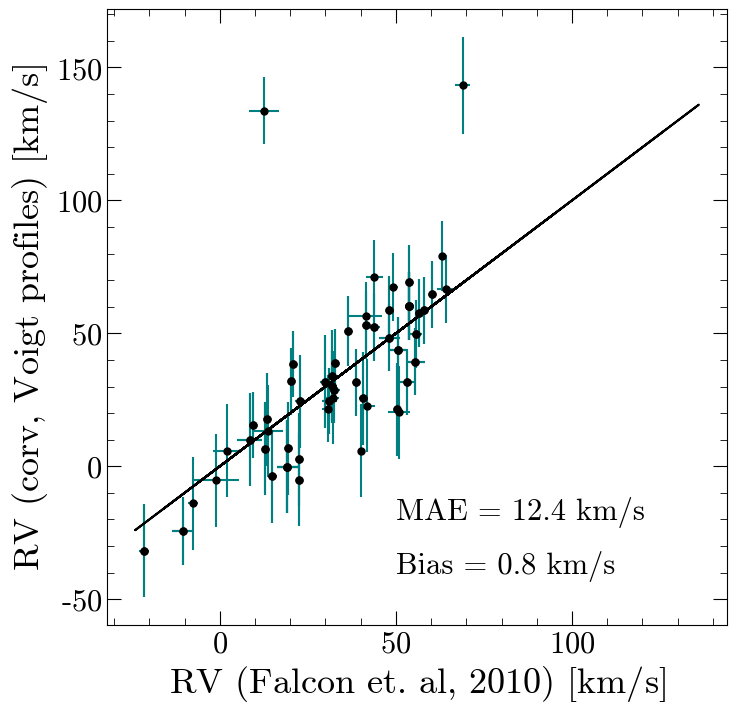

In [13]:
def linear(x):
    return x

plt.figure(figsize=(8,8))
plt.style.use('stefan.mplstyle')

plt.errorbar(falcon_xmatch['Adp-V'][np.abs(falcon_xmatch['corv_rv']) < 2500], falcon_xmatch['corv_rv'][np.abs(falcon_xmatch['corv_rv']) < 2500], 
             xerr = falcon_xmatch['e_Adp-V'][np.abs(falcon_xmatch['corv_rv']) < 2500], yerr = falcon_xmatch['corv_erv'][np.abs(falcon_xmatch['corv_rv']) < 2500],
             fmt='o', label = 'Data', color='black', ecolor = 'teal')
plt.plot(falcon_xmatch['vr'][np.abs(falcon_xmatch['corv_rv']) < 2500], linear(falcon_xmatch['vr'][np.abs(falcon_xmatch['corv_rv']) < 2500]), color = 'black')

plt.text(50, -20, 'MAE = {:2.1f} km/s'.format(mae))
plt.text(50, -40, 'Bias = {:2.1f} km/s'.format(bias))

ymin, ymax = plt.ylim()
plt.xlabel(r'RV (Falcon et. al, 2010) $[km/s]$')
plt.ylabel(r'RV (corv, Voigt profiles) $[km/s]$')

<a id="validation-template"></a>

**02. Validating RVs With Templates (Need to check/proofread)**

---

Next we validate `corv` using Koester templates.

In [14]:
falcon_xmatch['corv_rv_template'] = -9999 * np.ones(len(falcon_xmatch))
falcon_xmatch['corv_erv_template'] = -9999 * np.ones(len(falcon_xmatch))

In [15]:
figs = []

for j in tqdm( range(len(falcon_xmatch))):
    p,m,f = np.array(falcon_xmatch['col_p_m_f'][j].split('-')).astype(float)
    
    try:
        xid = SDSS.query_specobj(plate = p, mjd = m, fiberID = f)
    except ValueError:
        print('unknown error')
        
    try:
        sp = SDSS.get_spectra(matches=xid)
    except:
        print('http error')
        continue
    for i in range(len(sp[0:1])):
        wl = np.array(10**sp[i][1].data['loglam'])
        fl = np.array(sp[i][1].data['flux'])
        ivar = np.array(sp[i][1].data['ivar'])
                
        corvmodel = corv.models.make_koester_model(names = ['a','b','g','d'])
        param_res, rv_res, rv_init = corv.fit.fit_corv(wl, fl, ivar, corvmodel)        
        
        
    falcon_xmatch['corv_rv_template'][j] = (rv_res.params['RV'].value)
    falcon_xmatch['corv_erv_template'][j] = (rv_res.params['RV'].stderr)

  0%|                                                                                            | 0/97 [00:00<?, ?it/s]/home/arseneau/anaconda3/lib/python3.9/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),
100%|███████████████████████████████████████████████████████████████████████████████████| 97/97 [00:26<00:00,  3.62it/s]


In [16]:
mask_template = np.all([np.abs(falcon_xmatch['corv_rv']) < 2500, falcon_xmatch['s_n'] > 10], axis = 0)

rmse = 0
mae = 0
for i in range(len(falcon_xmatch['Adp-V'][mask_template])):
    rmse += (falcon_xmatch['Adp-V'][mask_template][i] - falcon_xmatch['corv_rv_template'][mask_template][i])**2
    mae += np.abs(falcon_xmatch['Adp-V'][mask_template][i] - falcon_xmatch['corv_rv_template'][mask_template][i])
    
rmse = np.sqrt( rmse / len(falcon_xmatch['Adp-V'][mask_template]))
mae = mae / len(falcon_xmatch['Adp-V'][mask_template])
bias = np.average(falcon_xmatch['Adp-V'][mask_template] - falcon_xmatch['corv_rv_template'][mask_template])

print('rmse: {:2.1f} km/s'.format(rmse))
print('mae: {:2.1f} km/s'.format(mae))
print('bias: {:2.1f} km/s'.format(bias))

rmse: 21.1 km/s
mae: 12.4 km/s
bias: -3.0 km/s


In [17]:
for i in range(len(falcon_xmatch)):
    if isnan(falcon_xmatch['corv_erv_template'][i]):
        falcon_xmatch['corv_erv_template'][i] = mae

Text(0, 0.5, 'RV (corv, Koester templates) $[km/s]$')

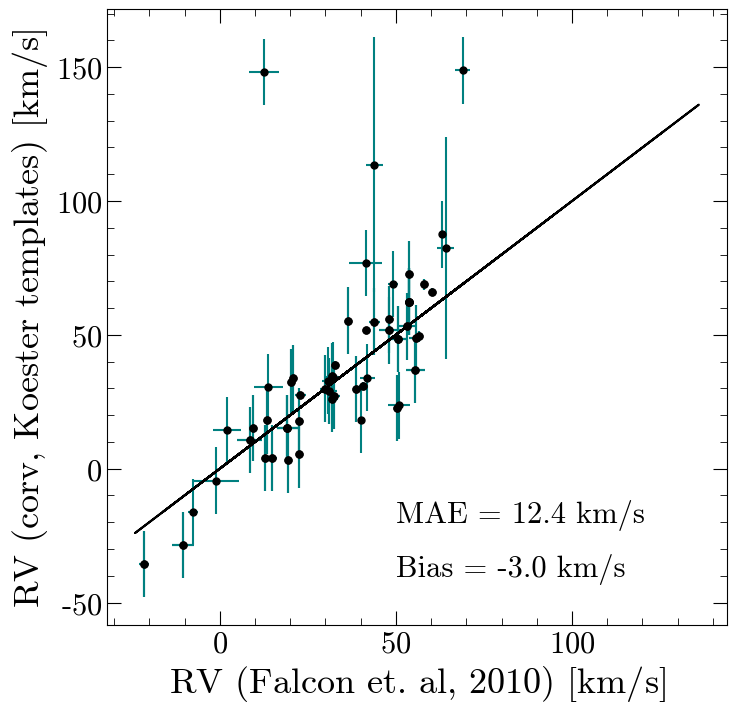

In [18]:
plt.figure(figsize=(8,8))
plt.style.use('stefan.mplstyle')

plt.errorbar(falcon_xmatch['Adp-V'][np.abs(falcon_xmatch['corv_rv_template']) < 2500], falcon_xmatch['corv_rv_template'][np.abs(falcon_xmatch['corv_rv_template']) < 2500], 
             xerr = falcon_xmatch['e_Adp-V'][np.abs(falcon_xmatch['corv_rv_template']) < 2500], yerr = falcon_xmatch['corv_erv_template'][np.abs(falcon_xmatch['corv_rv']) < 2500],
             fmt='o', label = 'Data', color='black', ecolor = 'teal')
plt.plot(falcon_xmatch['vr'][np.abs(falcon_xmatch['corv_rv']) < 2500], linear(falcon_xmatch['vr'][np.abs(falcon_xmatch['corv_rv_template']) < 2500]), color = 'black')

plt.text(50, -20, 'MAE = {:2.1f} km/s'.format(mae))
plt.text(50, -40, 'Bias = {:2.1f} km/s'.format(bias))


ymin, ymax = plt.ylim()
plt.xlabel(r'RV (Falcon et. al, 2010) $[km/s]$')
plt.ylabel(r'RV (corv, Koester templates) $[km/s]$')

<a id="validation-betwixt"></a>

**03. Comparison Of Methods**

---

Finally we compare the results from `corv` using Voigt fitting versus using Koester template fitting.

In [19]:
mask = np.all([mask_template, mask_voigt], axis = 0)

rmse = 0
mae = 0

for i in range(len(falcon_xmatch['corv_rv'][mask])):
    rmse += (falcon_xmatch['corv_rv'][mask][i] - falcon_xmatch['corv_rv_template'][mask][i])**2
    mae += np.abs(falcon_xmatch['corv_rv'][mask][i] - falcon_xmatch['corv_rv_template'][mask][i])
    
rmse = np.sqrt( rmse / len(falcon_xmatch['corv_rv'][mask]))
mae = mae / len(falcon_xmatch['corv_rv'][mask])
bias = np.average(falcon_xmatch['corv_rv'][mask] - falcon_xmatch['corv_rv_template'][mask])

print('rmse: {} km/s'.format(rmse))
print('mae: {:2.1f} km/s'.format(mae))
print('bias: {:2.1f} km/s'.format(bias))

rmse: 8.649812279599816 km/s
mae: 5.8 km/s
bias: -3.8 km/s


Text(0, 0.5, 'RV With Templates $[km/s]$')

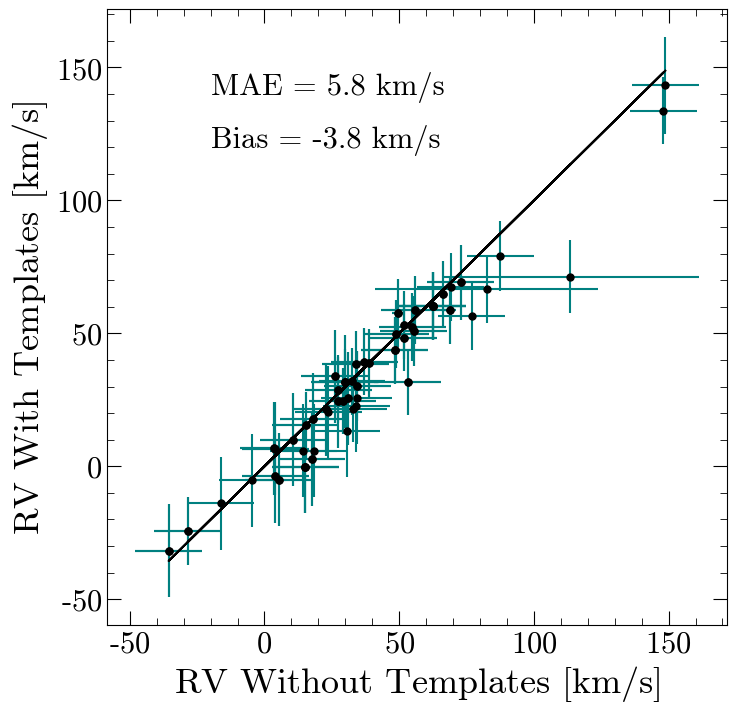

In [20]:
plt.figure(figsize=(8,8))
plt.style.use('stefan.mplstyle')

plt.errorbar(falcon_xmatch['corv_rv_template'], falcon_xmatch['corv_rv'], xerr=falcon_xmatch['corv_erv_template'], yerr=falcon_xmatch['corv_erv'], 
            fmt = 'o', label = 'Data', color='black', ecolor = 'teal')
plt.plot(falcon_xmatch['corv_rv_template'], linear(falcon_xmatch['corv_rv_template']), color = 'black')

plt.text(-20, 140, 'MAE = {:.1f} km/s'.format(mae))
plt.text(-20, 120, 'Bias = {:2.1f} km/s'.format(bias))

ymin, ymax = plt.ylim()
plt.xlabel(r'RV Without Templates $[km/s]$')
plt.ylabel(r'RV With Templates $[km/s]$')